# Benchmark PyTorch Models with APEBench

While foreign models cannot use advanced features of APEBench like correction
setups or differentiable physics training, it is still possible to benchmark
their performance on purely data-driven supervised learning tasks. This usually
follows a four-step pattern:

1. Scrape the training data trajectories and the test initial conditions from
   the APEBench scenario.
2. Use the training data trajectories to train the foreign model. (Or use a
   pretrained model.)
3. Rollout the foreign model for `scenario.test_temporal_horizon` steps from the
   test initial conditions.
4. Plug the resulting neural trajectories into
   `scenario.perform_tests_on_rollout` method to obtain a dictionary with the
   error rollouts according to all `scenario.report_metrics`.

Note that the step from (1.) -> (2.) can require a change in array format or
moving arrays to a different framework. So does step (3.) -> (4.).

This notebook uses Pytorch. Since PyTorch and JAX often conflict when installed
in the same conda environment, please have two separate environments at hand to
run this tutorial. Whenever, a part needs PyTorch, set the `RUN_PYTORCH` flag to
`True`. We will transfer data between PyTorch and JAX by writing the arrays as a
`.npy` file and reading them back in the other framework.

If you already have a pretrained model in PyTorch, you only have to scrape the
test initial conditions, write them out and then jump directly to step (3.).

In [1]:
RUN_PYTORCH = False

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

if RUN_PYTORCH:
    import torch
    import numpy as np
else:
    import apebench
    import numpy as np
    import jax.numpy as jnp
    import seaborn as sns
    from scipy import stats

/tmp/ipykernel_63364/1007276627.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Create Data with APEBench

As an example, we will use an advection scenario in difficulty mode with mostly
default settings.

In [2]:
if not RUN_PYTORCH:
    advection_scenario = apebench.scenarios.difficulty.Advection(
        # A simple optimization setup that will be mimicked by PyTorch
        optim_config="adam;10_000;constant;1e-4",
        # The default metric for APEBench scenarios is always `"mean_nRMSE"`. Let's
        # add some more metrics to the report. One based on the spectrum up until
        # (including) the fifth mode and a Sobolev-based metric that also considers
        # the first derivative.
        report_metrics="mean_nRMSE,mean_fourier_nRMSE;0;5;0,mean_H1_nRMSE",
    )

Create train **trajectories** and test **initial conditions** with APEBench.

In [3]:
if not RUN_PYTORCH:
    train_data = advection_scenario.get_train_data()
    print(train_data.shape)

(50, 51, 1, 160)


In [4]:
if not RUN_PYTORCH:
    test_ic_set = advection_scenario.get_test_ic_set()
    print(test_ic_set.shape)

(30, 1, 160)


In [5]:
if not RUN_PYTORCH:
    jnp.save("train_data.npy", train_data)
    jnp.save("test_ic_set.npy", test_ic_set)

## 2. Train a Model in PyTorch

Change the `RUN_PYTORCH` flag to `True` to run the PyTorch code. (Make sure to
change the ipykernel to an environment with PyTorch installed)

In [2]:
if RUN_PYTORCH:
    train_data = torch.from_numpy(np.load("train_data.npy"))
    test_ic_set = torch.from_numpy(np.load("test_ic_set.npy"))
    print(train_data.shape, test_ic_set.shape)

torch.Size([50, 51, 1, 160]) torch.Size([30, 1, 160])


### Data Preprocessing

From here on, you are free to do with the `train_data` what you what. The
simplest approach would be **one-step supervised learning**. For this, we slice
windows of length two across both the trajectory and the time axis.

In [3]:
if RUN_PYTORCH:
    substacked_data = torch.stack(
        [
            torch.stack([td[i : i + 2] for i in range(td.shape[0] - 1)])
            for td in train_data
        ]
    )
    # substacked_data = torch.tensor(substacked_data)
    print(substacked_data.shape)

torch.Size([50, 50, 2, 1, 160])


Then, we can merge sample and window axis into a joint batch axis.

In [4]:
if RUN_PYTORCH:
    train_windows = substacked_data.flatten(0, 1)
    print(train_windows.shape)

torch.Size([2500, 2, 1, 160])


### Setting up PyTorch Dataloader

In [5]:
if RUN_PYTORCH:
    inputs, targets = train_windows[:, 0], train_windows[:, 1]

In [6]:
if RUN_PYTORCH:
    dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(inputs, targets),
        batch_size=20,
        shuffle=True,
    )

### Model Definition

Just a simple ReLU feedforward ConvNet.

In [7]:
if RUN_PYTORCH:

    class CNN(torch.nn.Module):
        def __init__(self, width: int, depth: int):
            super().__init__()
            module_list = []

            conv_lift = torch.nn.Conv1d(
                1, width, kernel_size=3, padding=1, padding_mode="circular"
            )
            module_list.append(conv_lift)
            module_list.append(torch.nn.ReLU())

            for _ in range(depth - 1):
                conv = torch.nn.Conv1d(
                    width, width, kernel_size=3, padding=1, padding_mode="circular"
                )
                module_list.append(conv)
                module_list.append(torch.nn.ReLU())

            conv_proj = torch.nn.Conv1d(
                width, 1, kernel_size=3, padding=1, padding_mode="circular"
            )
            module_list.append(conv_proj)

            self.sequential_modules = torch.nn.Sequential(*module_list)

        def forward(self, x):
            return self.sequential_modules(x)

### Training Loop

In [8]:
if RUN_PYTORCH:
    num_epochs = 10_000 / len(dataloader)
    print(num_epochs)  # 80

80.0


In [9]:
if RUN_PYTORCH:
    DEVICE = "cuda"

    model = CNN(34, 10).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    loss_history = []
    for epoch in tqdm(range(int(num_epochs))):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


Let's visualize the loss history. It's a bit noisy towards the end, but let's
stick with a constant learning rate for simplicity.

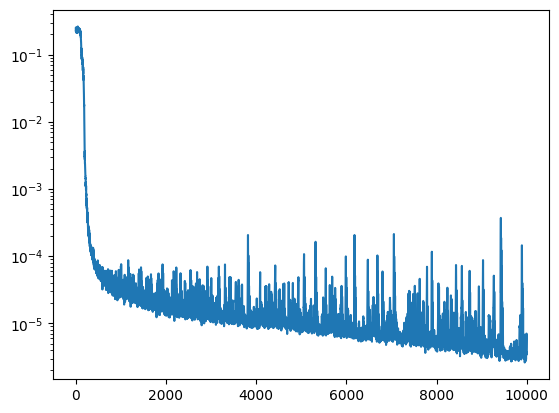

In [10]:
if RUN_PYTORCH:
    plt.semilogy(loss_history)

## 3. Rollout the Model

⚠️ The neural rollout must be **without** the initial conditions.

In [11]:
if RUN_PYTORCH:
    neural_rollout = []
    current_state = test_ic_set.to(DEVICE)
    for i in range(200):
        with torch.no_grad():
            current_state = model(current_state)
        neural_rollout.append(current_state.cpu())

    neural_rollout = torch.stack(neural_rollout, dim=1)
    print(neural_rollout.shape)

torch.Size([30, 200, 1, 160])


In [12]:
if RUN_PYTORCH:
    # Write to disk
    np.save("neural_rollout.npy", neural_rollout)

## 4. Perform tests on the rollout

Change the `RUN_PYTORCH` flag back to `False` to run the JAX code. (Make sure to
change the ipykernel to an environment with JAX/APEBench installed)

In [3]:
if not RUN_PYTORCH:
    neural_rollout = jnp.load("neural_rollout.npy")
    print(neural_rollout.shape)

(30, 200, 1, 160)


In [4]:
if not RUN_PYTORCH:
    test_dict = advection_scenario.perform_tests_on_rollout(neural_rollout)

Now we find the same keys in the `test_dict` as set up for the `report_metrics`

In [5]:
if not RUN_PYTORCH:
    print(test_dict.keys(), advection_scenario.report_metrics)

dict_keys(['mean_nRMSE', 'mean_fourier_nRMSE;0;5;0', 'mean_H1_nRMSE']) mean_nRMSE,mean_fourier_nRMSE;0;5;0,mean_H1_nRMSE


For each key, there is an array attached. It is of the shape `(num_seeds,
test_temporal_horizon)`. Since, the `neural_rollout` did not have a leading
`num_seeds` axis, this axis appears as singleton. The axis thereafter is due to
the 200 time steps performed in the test.

In [6]:
if not RUN_PYTORCH:
    for key, value in test_dict.items():
        print(f"{key}: {value.shape}")

mean_nRMSE: (1, 200)
mean_fourier_nRMSE;0;5;0: (1, 200)
mean_H1_nRMSE: (1, 200)


### Rollout Metrics

Let's visualize the error over time. The metric that includes the derivative
(`"mean_H1_nRMSE"`) is worse, likely because **nonlinear** networks applied to
linear time stepping problems produce spurious energy in higher modes. This is
problematic since linear PDEs on periodic BCs remain bandlimited.

However, this is not a problem of PyTorch but a general problem of neural
emulators for linear PDEs. Hence, let's just acknowledge that the model performs
reasonable for at least ~50 time steps which is remarkable since it was only
trained to predict one step into the future and never multiple steps
autoregressively.

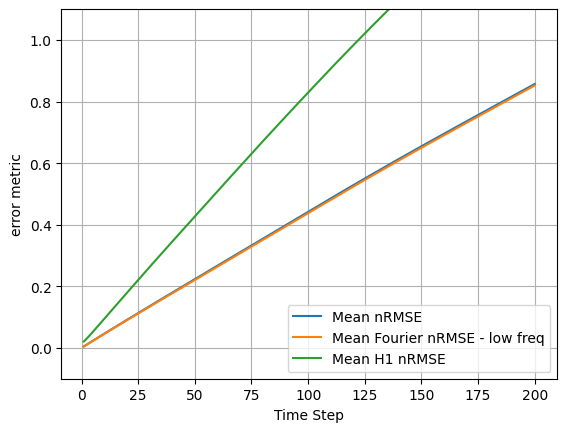

In [7]:
if not RUN_PYTORCH:
    time_steps = jnp.arange(1, advection_scenario.test_temporal_horizon + 1)
    plt.plot(
        time_steps,
        test_dict["mean_nRMSE"][0],
        label="Mean nRMSE",
    )
    plt.plot(
        time_steps,
        test_dict["mean_fourier_nRMSE;0;5;0"][0],
        label="Mean Fourier nRMSE - low freq",
    )
    plt.plot(
        time_steps,
        test_dict["mean_H1_nRMSE"][0],
        label="Mean H1 nRMSE",
    )
    plt.xlabel("Time Step")
    plt.ylabel("error metric")
    plt.legend()
    plt.grid()
    plt.ylim(-0.1, 1.1)

### Aggregated Metrics

Similar to the [APEBench paper](https://arxiv.org/abs/2411.00180), let us
aggregate over the first 100 time steps with a geometric mean.

In [8]:
if not RUN_PYTORCH:
    UP_TO = 100
    test_dict_gmean = {
        key: stats.gmean(value[:, :UP_TO], axis=1) for key, value in test_dict.items()
    }
    print(test_dict_gmean)

{'mean_nRMSE': array([0.17082268], dtype=float32), 'mean_fourier_nRMSE;0;5;0': array([0.16836041], dtype=float32), 'mean_H1_nRMSE': array([0.33509955], dtype=float32)}


## Comparing against a ConvNet trained within APEBench

Let's train a similar ConvNet using the mechanisms of APEBench

In [9]:
if not RUN_PYTORCH:
    data, trained_net = advection_scenario(
        task_config="predict",  # Means the nextwork fully replaces the simulator
        network_config="Conv;34;10;relu",  # 34 hidden width across 10 hidden depth with relu activation
        train_config="one",  # One-Step supervised learning
        num_seeds=1,  # Only one seed for this example
    )

E: 00079, B: 00124: 100%|██████████| 10000/10000 [00:47<00:00, 212.56it/s]


Typical APEBench pattern is to melt the wide format `data` into long formats
which are handy to work with when using seaborn. See also
[here](https://pandas.pydata.org/docs/user_guide/reshaping.html#melt-and-wide-to-long)
for a guide in Pandas.

In [10]:
if not RUN_PYTORCH:
    loss_data = apebench.melt_loss(data)
    metric_data = apebench.melt_metrics(
        data,
        metric_name=advection_scenario.report_metrics.split(","),
    )

Let's visualize the training loss history (Note that by default, APEBench does
not record the training loss every update step, but only every 100th step.)

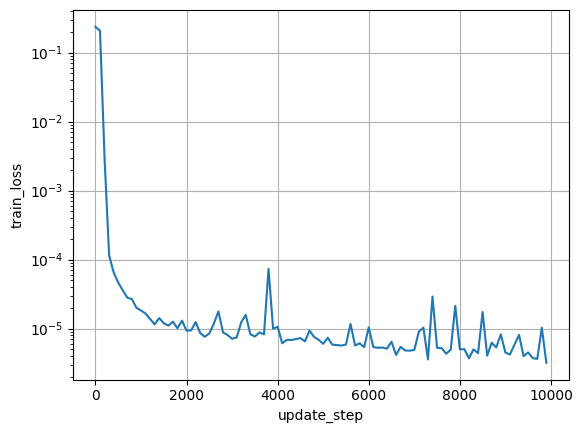

In [11]:
if not RUN_PYTORCH:
    sns.lineplot(loss_data, x="update_step", y="train_loss")
    plt.yscale("log")
    plt.grid()

Let's compare the three metric rollouts against the results from the PyTorch run. The PyTorch model seems to be particularly bad. What is going on? 🤔

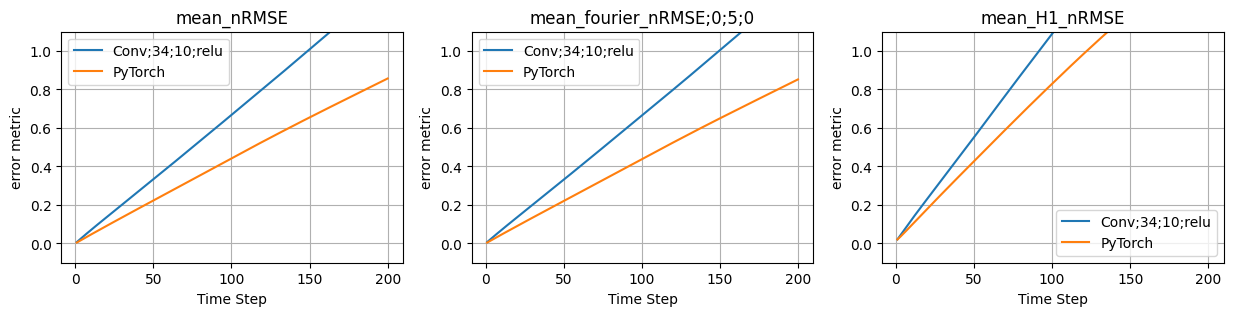

In [12]:
if not RUN_PYTORCH:
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    for i, metric in enumerate(advection_scenario.report_metrics.split(",")):
        sns.lineplot(data=metric_data, x="time_step", y=metric, hue="net", ax=axs[i])
        axs[i].plot(
            time_steps,
            test_dict[metric][0],
            label="PyTorch",
        )
        axs[i].legend()
        axs[i].set_title(metric)
        axs[i].set_xlabel("Time Step")
        axs[i].set_ylabel("error metric")
        axs[i].grid()
        axs[i].set_ylim(-0.1, 1.1)

## Comparing against multiple seeds with APEBench

Let's see if this was just an unlucky seed. To check, we will run multiple
seeds. This is one of the big strengths of APEBench. If a network run, does not
fully utilize the GPU (oftentimes the case in 1D), one can get seed statistics
in parallel for a small overhead.

In [13]:
if not RUN_PYTORCH:
    data_s, trained_net_s = advection_scenario(
        task_config="predict",
        network_config="Conv;34;10;relu",
        train_config="one",
        num_seeds=10,  # Now 10 seeds at the same time
    )

E: 00079, B: 00124: 100%|██████████| 10000/10000 [02:03<00:00, 81.18it/s]


Similar melting.

In [14]:
if not RUN_PYTORCH:
    loss_data_s = apebench.melt_loss(data_s)
    metric_data_s = apebench.melt_metrics(
        data_s, metric_name=advection_scenario.report_metrics.split(",")
    )

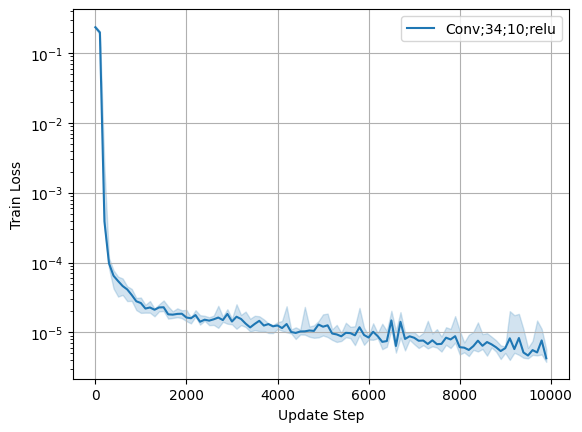

In [15]:
if not RUN_PYTORCH:
    sns.lineplot(
        data=loss_data_s,
        x="update_step",
        y="train_loss",
        hue="net",
        estimator="median",
        errorbar=("pi", 50),
    )
    plt.xlabel("Update Step")
    plt.ylabel("Train Loss")
    plt.legend()
    plt.grid()
    plt.yscale("log")

The seed statistics show that this single seed of before was particularly bad.
In the median performance, the APEBench model is better than the PyTorch model.
Of course, for a conclusive statement, the PyTorch model would have also needed
to be trained using multiple seeds. Ultimately, one would require a hypothesis
test.

This is also good motivation why seed statistics are important. Especially for
autoregressive emulators for which errors compound over time, the effect of an
unlucky seed can be especially pronounced. This concept of running multiple
seeds is deeply baked into APEBench and can be obtained virtually for free in
case of 1D emulation and low-resolution 2D emulation.

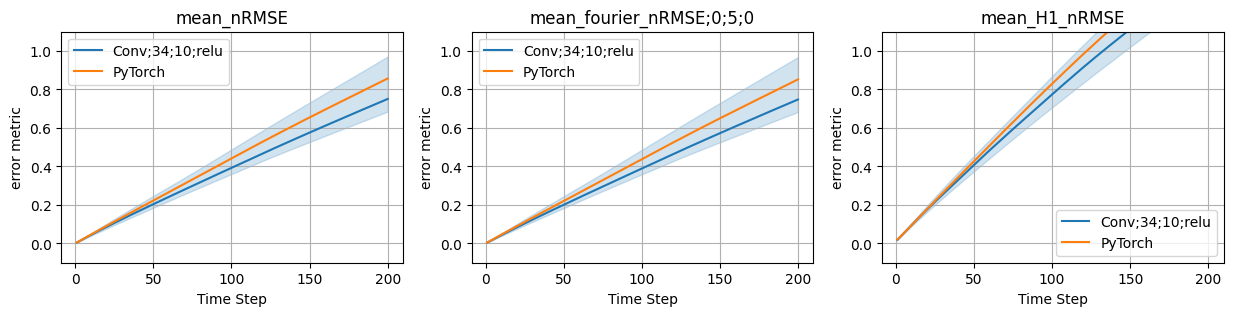

In [16]:
if not RUN_PYTORCH:
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    for i, metric in enumerate(advection_scenario.report_metrics.split(",")):
        sns.lineplot(
            data=metric_data_s,
            x="time_step",
            y=metric,
            hue="net",
            estimator="median",
            errorbar=("pi", 50),
            ax=axs[i],
        )
        axs[i].plot(
            time_steps,
            test_dict[metric][0],
            label="PyTorch",
        )
        axs[i].legend()
        axs[i].set_title(metric)
        axs[i].set_xlabel("Time Step")
        axs[i].set_ylabel("error metric")
        axs[i].grid()
        axs[i].set_ylim(-0.1, 1.1)

Let's plot the seeds' performances individually.

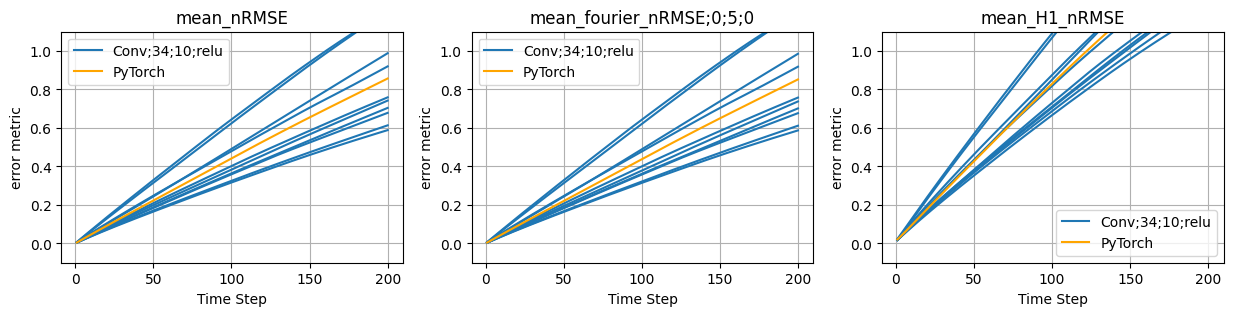

In [17]:
if not RUN_PYTORCH:
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    for i, metric in enumerate(advection_scenario.report_metrics.split(",")):
        sns.lineplot(
            data=metric_data_s,
            x="time_step",
            y=metric,
            hue="net",
            estimator=None,
            errorbar=None,
            units="seed",
            ax=axs[i],
        )
        axs[i].plot(
            time_steps,
            test_dict[metric][0],
            color="orange",
            label="PyTorch",
        )
        axs[i].legend()
        axs[i].set_title(metric)
        axs[i].set_xlabel("Time Step")
        axs[i].set_ylabel("error metric")
        axs[i].grid()
        axs[i].set_ylim(-0.1, 1.1)